In [231]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

repo_path = "/content/cit19_project"

if os.path.exists(repo_path): #check if repo_path exists. If it does, then it pulls the main branch from our git repo.
    %cd {repo_path}
    !git pull origin main
else:
    %cd /content
    !git clone https://github.com/XebastianePitogo/cit19_project.git
    %cd cit19_project #If none, colab will git clone the repo in path </content> and change directory inside repo.

print("\ncheck ls:")
!ls #list all folder and files inside repo to confirm it exists.

/content/cit19_project
From https://github.com/XebastianePitogo/cit19_project
 * branch            main       -> FETCH_HEAD
Already up to date.

check ls:
 CC19_project_PHASE3.ipynb   README.md		      Student-Employability-Datasets.csv
 preprocessed_df.csv	    'RSTUDIO_CC19 RESEARCH'


In [232]:
#%cd 'RSTUDIO_CC19 RESEARCH/'
df = pd.read_csv("preprocessed_df.csv")

In [233]:
df.head()

,Unnamed: 0,GENERAL.APPEARANCE,MANNER.OF.SPEAKING,PHYSICAL.CONDITION,MENTAL.ALERTNESS,SELF.CONFIDENCE,ABILITY.TO.PRESENT.IDEAS,COMMUNICATION.SKILLS,CLASS_factor,CLASS_encoded.CLASS_factorEmployable,CLASS_encoded.CLASS_factorLessEmployable
0,1,4,5,4,5,5,5,5,Employable,1,0
1,2,4,4,4,4,4,4,3,Employable,1,0
2,3,4,3,3,3,3,3,2,LessEmployable,0,1
3,4,3,3,3,2,3,3,3,LessEmployable,0,1
4,5,4,4,3,3,4,4,3,Employable,1,0


In [234]:
# Step 1: Model Selection

# Objective: Based on the nature of the data and the problem type (e.g., classification, or regression), choose the best model for the problem.

# Tasks:

# 1. Understand the Problem
# The task to be done is a classification problem as it predicts whether the student is employable or less employable (<*CLASS> is target variable, separated to factor and encoded for different models.)

#         We will utilize classification metrics for classification as it is more appropriate in our model.
#         Classification: Accuracy, Precision, Recall, F1-score
#
# 2. Choose Candidate Models
#     Consider the dataset size, feature complexity, and interpretability.

#     Classification:
#         Start with Logistic Regression or Decision Trees for interpretability.
#         If these models underperform, test Random Forest, Support Vector Machines (SVM), or k-NN.

# 3. Consider Model Complexity
#
#     We will use simple models first then follow up with more complex if the simple models underperform.

In [235]:
# Step 2: Model Training

# Objective: Train the model(s) on the prepared dataset and tune their hyperparameters (if applicable).

# Define features (exclude the target variables which are *CLASSES)
X = df.iloc[:, :-3]

# Define target (assuming CLASS_factor is the main target)
#y = df["CLASS_factor"]

y = df.iloc[:, -2:].values #select one hot encoded target variable column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #80/20 ratio

#     Train the Model:
#         Train the selected model on the training data.

X_train, X_test, y_train, y_test = train_test_split(X, y_Logistic, test_size=0.2, random_state=42, stratify=y_Logistic)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [236]:
# We firstly used the simple models as our dataset has few features, small dataset size
# and has meaningful output based from our input for interpretability,
# in decision trees(all likert scaled features will eventually determine if a student is employable or less employable)

# The industry standard for accuracy in models typically ranges from 70% to 90%.

# Step 3 Model fitting with Evaluation metrics
# Models to be used:
# Logistic Regression
# Decision Tree Classifier
# Random Forest Classifier
# XGBoost Classifier


In [237]:
#K Nearest Neighbour

knn_model = KNeighborsClassifier(n_neighbors=15, metric="manhattan")
knn_model.fit(X_train_scaled, y_train)

y_pred_knn = knn_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_knn)
print(classification_report(y_test, y_pred_knn))

print(f"Accuracy: {accuracy:.2f}")

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       346
           1       0.81      0.72      0.76       251

    accuracy                           0.81       597
   macro avg       0.81      0.80      0.80       597
weighted avg       0.81      0.81      0.81       597

Accuracy: 0.81


In [238]:
#DECISION TREE

CLFmodel = DecisionTreeClassifier(
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
)
CLFmodel.fit(X_train,y_train)

y_pred_clf = CLFmodel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_clf)
print(classification_report(y_test, y_pred_clf))
print(f"Accuracy: {accuracy:.2f}")

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       346
           1       0.72      0.72      0.72       251

    accuracy                           0.76       597
   macro avg       0.76      0.76      0.76       597
weighted avg       0.76      0.76      0.76       597

Accuracy: 0.76


In [239]:
#RANDOM FOREST

RFmodel = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
RFmodel.fit(X_train, y_train)

y_pred_rf = RFmodel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy:.2f}")

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       346
           1       0.85      0.66      0.74       251

    accuracy                           0.81       597
   macro avg       0.82      0.79      0.80       597
weighted avg       0.82      0.81      0.80       597

Accuracy: 0.81


In [240]:
#XGBOST

XGBmodel = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
XGBmodel.fit(X_train, y_train)

y_pred_xgb = XGBmodel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xgb)
print(classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy:.2f}")

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       346
           1       0.88      0.70      0.78       251

    accuracy                           0.84       597
   macro avg       0.85      0.82      0.83       597
weighted avg       0.84      0.84      0.83       597

Accuracy: 0.84


In [241]:
#SUPPORT VECTOR MACHINE

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

SVMmodel = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    probability=True,
    random_state=42
)
SVMmodel.fit(X_train_scaled, y_train)

y_pred_svm = SVMmodel.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_svm)
print(classification_report(y_test, y_pred_svm))
print(f"Accuracy: {accuracy:.2f}")

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       346
           1       0.85      0.61      0.71       251

    accuracy                           0.79       597
   macro avg       0.81      0.77      0.77       597
weighted avg       0.80      0.79      0.78       597

Accuracy: 0.79


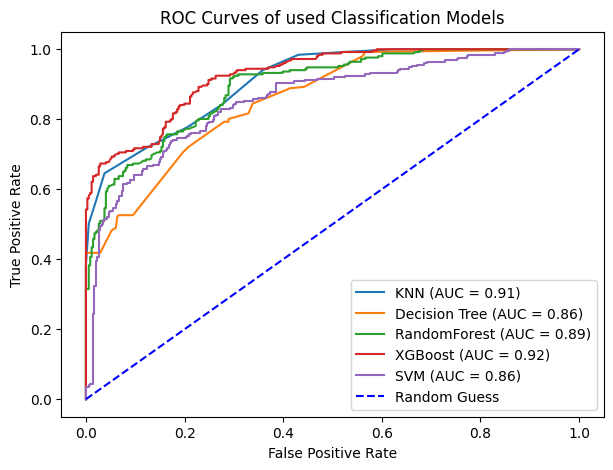

In [242]:
y_pred_knn = knn_model.predict_proba(X_test_scaled)[:, 1]
y_pred_clf = CLFmodel.predict_proba(X_test)[:, 1]
y_pred_rf = RFmodel.predict_proba(X_test)[:, 1]
y_pred_xgb = XGBmodel.predict_proba(X_test)[:, 1]
y_pred_svm = SVMmodel.predict_proba(X_test_scaled)[:, 1]

test_df = pd.DataFrame(
    {'True': y_test, 'KNN': y_pred_knn,'Decision Tree': y_pred_clf, 'RandomForest': y_pred_rf, 'XGBoost': y_pred_xgb, 'SVM': y_pred_svm})

plt.figure(figsize=(7, 5))

for model in ['KNN', 'Decision Tree','RandomForest', 'XGBoost', 'SVM']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'b--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of used Classification Models')
plt.legend()
plt.show()


In [243]:
# Step 4: Model Improvement
# Based from the evaluation metrics, our models did fair as the desired scores typically range above 70% and does not need any improvement.

# We also compared if more complex models such as
# Random Forest and XGBoost may produce similar results than the simpler models, which did good.

In [244]:
# Step 5: Model Interpretation and Reporting
# Interpretation

# # The ROC curves and classification metrics suggest that XGBoost (AUC = 0.92, accuracy = 0.84) performed
# best in predicting student employability based on Likert scale responses, showing a strong balance between
# precision and recall. While the remaining models still show good evaluation metric scores. The following
# models ranked from best to least performance in predicting whether a Filipino student is employable or less
# employable are as follows: XGBoost, KNN, Random Forest, SVM, and lastly, Decision Tree.

# # From our findings, we suggest XGBoost to be the appropriate categorical model in predicting student employability.